https://towardsdatascience.com/schoenfeld-residuals-the-idea-that-turned-regression-modeling-on-its-head-b1f1fd293f87

## 1.1. Specify Constants

<link href="https://fonts.googleapis.com/css2?family=Roboto+Mono&display=swap" rel="stylesheet">
<span style="font-family: 'Lobster', cursive; font-size: 20px;">
In this example, we will simulate some data using parameters to specify the size and column names of the  dataset created. We will also include some parameters to constain the values simulated. Finally, we will explicitly state the mapping between concepts in our analysis (e.g. whether someone is alive or dead) and values used in the notebook.
</span>

In [89]:
from enum import Enum


class SimParams(Enum):

    N_PATIENTS = 100
    MAX_AGE = 85
    MAX_SURVIAL_DAYS = 3650


class ColumnNames(str, Enum):

    ID = "id"
    AGE = "age"
    SURVIVAL_TIME = "survival time"
    SURVIVAL_STATUS = "survival status"
    PRIOR_SURGERY = "prior surgery"
    TRANSPLANT_STATUS = "transplant status"

    def __str__(self):
        return self.value


class SurvivalStatus(Enum):

    ALIVE = 0
    DEAD = 1

    def __repr__(self):
        return self.value

## 1.2. Specify dataframe schema

<span style="font-family: 'Lobster', cursive; font-size: 20px;">
Specifying the schema allows us to validate incoming data and explicitly set out the assumptions made when developing the code.
</span>

In [61]:
import pandera as pa
from pandera import Column, DataFrameSchema, Check, Index

schema = DataFrameSchema(
    {
        ColumnNames.AGE: Column(int, Check.in_range(1, SimParams.MAX_AGE.value)),
        ColumnNames.SURVIVAL_TIME: Column(int, Check.greater_than(0)),
        ColumnNames.SURVIVAL_STATUS: Column(
            int, Check.isin([x.value for x in SurvivalStatus])
        ),
        ColumnNames.PRIOR_SURGERY: Column(int, Check.isin([0, 1])),
        ColumnNames.TRANSPLANT_STATUS: Column(int, Check.isin([0, 1])),
    },
    index = Index(name=ColumnNames.ID, dtype=int),
    strict=True,
    coerce=True,
)

## 1.3. Simulate some data

<span style="font-family: 'Lobster', cursive; font-size: 20px;">
To get us started, we will create some basic simulated data that meets the specifications we have outlined. In later examples, we can make things more complicated and introduce statistical dependencies - however for now we'll keep it very simple.
</span>

In [83]:
import numpy as np
import pandas as pd

np.random.seed(42)

df = pd.DataFrame(
    data = {
        ColumnNames.AGE: 1 + np.random.randint(
            SimParams.MAX_AGE.value, size=SimParams.N_PATIENTS.value
        ),
        ColumnNames.SURVIVAL_TIME: np.random.randint(
            SimParams.MAX_SURVIAL_DAYS.value, size=SimParams.N_PATIENTS.value
        ),
        ColumnNames.SURVIVAL_STATUS: np.random.randint(
            2, size=SimParams.N_PATIENTS.value
        ),
        ColumnNames.PRIOR_SURGERY: np.random.randint(
            2, size=SimParams.N_PATIENTS.value
        ),
        ColumnNames.TRANSPLANT_STATUS: np.random.randint(
            2, size=SimParams.N_PATIENTS.value
        ),
    },
    index = pd.RangeIndex(stop=SimParams.N_PATIENTS.value, name=ColumnNames.ID)        
)


## 1.4. Validate schema on dataframe

Finally, we'll take advantage of the hard work above and check that our dataframe matches our expectations. Think of validation as a form of testing that improves the quality of your work and catches things that you might not have considered. Being efficient at this will then give you and your colleagues more time to work on other things.

In [84]:
df = schema.validate(df)

df = df.sort_values(by=ColumnNames.SURVIVAL_TIME).reset_index()

## 1.5. Summarize Data

<span style="font-family: 'Lobster', cursive; font-size: 20px;">
Before modelling the data, it's good to check what the properties of the data are - here, the mean will tell us the proportion of patients with prior surgery, transplant and the survival outcome event:
</span>

In [85]:
df.mean()

id                     49.50
age                    42.58
survival time        1986.00
survival status         0.52
prior surgery           0.57
transplant status       0.52
dtype: float64

# 2. Fit Cox Proportional Hazards Model 

<span style="font-family: 'Lobster', cursive; font-size: 20px;">
Use the lifelines package to fit a Cox Proportional Hazards model:
</span>

In [93]:
from lifelines import CoxPHFitter

cph_model = CoxPHFitter()
input_df = df.drop(columns=ColumnNames.ID)

cph_model.fit(
    df=input_df, 
    duration_col=ColumnNames.SURVIVAL_TIME,
    event_col=ColumnNames.SURVIVAL_STATUS,
)

cph_model.print_summary()

<lifelines.CoxPHFitter: fitted with 100 total observations, 48 right-censored observations>
             duration col = 'survival time'
                event col = 'survival status'
      baseline estimation = breslow
   number of observations = 100
number of events observed = 52
   partial log-likelihood = -190.79
         time fit was run = 2024-07-20 19:17:37 UTC

---
                   coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                          
age               -0.00      1.00      0.01           -0.01            0.01                0.99                1.01
prior surgery      0.18      1.19      0.30           -0.40            0.76                0.67                2.13
transplant status  0.04      1.04      0.29           -0.53            0.60                0.59                1.81

                   cmp to     z    p  -log2(p)
covariate                                     
age                  0.00 -0.09 0.93      0.11
prior surgery        0.00  0.59 0.55      0.86
transplant status    0.00  0.12 0.90      0.15
---
Concordance = 0.54
Partial AIC = 387.58
log-likelihood ratio test = 0.42 on 3 df
-log2(p) of ll-ratio test = 0.10

## 2.2. Schoenfeld Residuals

Residuals normally capture the difference between the response observed for a set of input parameters and the response predicted by the model for those same input predictors. However for schoenfeld residuals, we want to get the expected input parameters for a given response - for example, what is the expected age of patients at risk of dying on day 10, or the expected transplant status of patients at risk of dying on day 100. The Schoenfeld residuals are then the difference between the actual values in the dataset and this expected value.

In contrast to other kinds of residuals, the number of Schoenfeld residuals depends on the number of patients at risk. Therefore, for most survival curves, the number of Schoenfeld residuals declines with time.




In [94]:
scaled_schoenfeld_residuals = cph_model.compute_residuals(training_dataframe=input_df, kind='scaled_schoenfeld')

<Axes: >

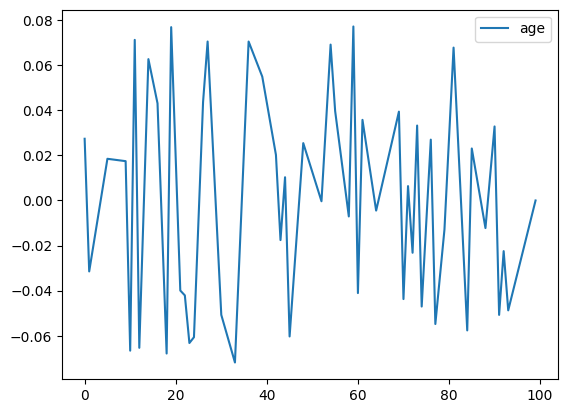

In [96]:
scaled_schoenfeld_residuals.plot(kind='line', y='age')

In [112]:
import statsmodels.stats.diagnostic as diag

ljung_box_options = {
    "lags":[40], 
    "boxpierce":True, 
    "model_df":0, 
    "period":None, 
    "return_df":None
}

autocorrl_diagnostics = []
PREDICTOR = 'Predictor'

for column_name, col_data in scaled_schoenfeld_residuals.items():
    column_diagnostics = diag.acorr_ljungbox(x=col_data, **ljung_box_options)
    column_diagnostics[PREDICTOR] = column_name
    autocorrl_diagnostics.append(column_diagnostics)

autocorrl_diagnostics = pd.concat(autocorrl_diagnostics, axis=0)

In [125]:
critical_value = 0.05

ljung_box_violations = autocorrl_diagnostics.query(f"lb_pvalue <= {critical_value}")
box_pierce_violations = autocorrl_diagnostics.query(f"bp_pvalue <= {critical_value}")

if not ljung_box_violations.empty:
    raise ValueError(f"Autocorrelations detected for {ljung_box_violations[PREDICTOR].to_list()}")

if not box_pierce_violations.empty:
    raise ValueError(f"Autocorrelations detected for {box_pierce_violations[PREDICTOR].to_list()}")


In [124]:
f"Autocorrelations detected for {['a','v','b']}"


"Autocorrelations detected for ['a', 'v', 'b']"